<h1>M. Nielsen, Chapter 6, third cnn model (tanh)</h1>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os
import numpy as np
import time
import random
import tensorflow as tf

In [5]:
from matplotlib import pyplot as plt

In [8]:
os.chdir(r"C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter3\20211119\multi_layer")

In [10]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

<h1>load data</h>

In [12]:
###############################################
#    load data from local directory
###############################################

train_x, train_y, val_x, val_y, test_x, test_y = [], [], [], [], [], []

training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

for tra in training_data:
    img_tra_x = tra[0].reshape(28,28).tolist()
    img_tra_y = np.array(np.argmax(tra[1]), dtype=np.uint8)
    train_x.append(img_tra_x)
    train_y.append(img_tra_y)
print(np.shape(train_x))

for val in validation_data:
    img_val_x = val[0].reshape(28,28)
#     img_val_y = np.array(np.argmax(val[1]), dtype=np.uint8)
    img_val_y = np.array(val[1], dtype=np.uint8)
    val_x.append(img_val_x)
    val_y.append(img_val_y)
print(np.shape(val_x))

for tes in test_data:
    img_tes_x = tes[0].reshape(28,28)
    img_tes_y = np.array(tes[1], dtype=np.uint8)
    test_x.append(img_tes_x)
    test_y.append(img_tes_y)
print(np.shape(test_x))


train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
val_y = np.array(val_y)
test_y = np.array(test_y)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [14]:
# ###############################################
# #    checking data format:
# ###############################################
# plt.imshow(train_x[0], interpolation='none')
# plt.show()
# print('img label:', train_y[0])

# plt.imshow(val_x[0], interpolation='none')
# plt.show()
# print('img label:', val_y[0])

# plt.imshow(test_x[0], interpolation='none')
# plt.show()
# print('img label:', test_y[0])


<h1>Trying Implementing the third CNN model as described in M. Nielsen, Chapter 6</h1>	

In [16]:
# Using the tanh activation function Several times earlier in the book 
# I've mentioned arguments that the tanh function may be a better activation 
# function than the sigmoid function. We've never acted on those 
# suggestions, since we were already making plenty of progress with the
# sigmoid. But now let's try some experiments with tanh as our activation
# function. Try training the network with tanh activations in the 
# convolutional and fully-connected layers

<h1>Reshape data</h1>

In [18]:
# reshape data
train_x = train_x.reshape(np.shape(train_x)[0], np.shape(train_x)[1], np.shape(train_x)[2], 1)
val_x = val_x.reshape(np.shape(val_x)[0], np.shape(val_x)[1], np.shape(val_x)[2], 1)
test_x = test_x.reshape(np.shape(test_x)[0], np.shape(test_x)[1], np.shape(test_x)[2], 1)

train_y = tf.one_hot(train_y.astype(np.int32), depth=10)
val_y = tf.one_hot(val_y.astype(np.int32), depth=10)
test_y = tf.one_hot(test_y.astype(np.int32), depth=10)

AttributeError: 
        'EagerTensor' object has no attribute 'astype'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

<h1>Build Network model (tanh)</h1>

In [19]:
################################################################
#   first CNN network as described in chapter 6
################################################################
tf.random.set_seed(42)
################################################################

################################################################
# construct netwoek model

input_shape = (28, 28, 1)

model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Conv2D( # no padding
        20,
        (5,5),
        activation=tf.nn.tanh,
        input_shape=input_shape
    )
)

model.add(
    tf.keras.layers.MaxPool2D(
        strides=(2,2)
    )
)

model.add(
    tf.keras.layers.Conv2D( # no padding
        40,
        (5,5),
        activation=tf.nn.tanh,
    )
)

model.add(
    tf.keras.layers.MaxPool2D(
        strides=(2,2)
    )
)

model.add(
    tf.keras.layers.Flatten()
)

model.add(
    tf.keras.layers.Dense(
        100,
        activation=tf.nn.tanh
    )
)

model.add(
    tf.keras.layers.Dense(
        10,
        activation=tf.nn.softmax,
    )
)
################################################################

################################################################
# compile model
n_eph = 60
eta = 0.1
model.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=eta,
        momentum=0.0,
        nesterov=False,
        name="SGD"),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

################################################################
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 40)          0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               64100     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

<h1>Train Network</h1>

In [20]:
################################################################
# save the model when val_acc is best
checkpoint_filepath = r'C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\save_model\cnn_tanh\cnn_tanh'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
################################################################

################################################################
#    train model  (how do i randomize mini_batches?)
batch_size = 10
n_eph = 60

ts = time.time()
history = model.fit(
    train_x, train_y, 
    epochs=n_eph,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
    callbacks=[model_checkpoint_callback],
    shuffle=True
)
te = time.time()

print('total time:', te - ts)


acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
################################################################


################################################################
#    load the weights for the best epoch (best val accuracy)
model.load_weights(checkpoint_filepath)

################################################################

################################################################
#    evaluate test data at the best epoch
[test_data_loss, test_data_accuracy] = model.evaluate(
    test_x, test_y,
    batch_size=len(test_x)
)
################################################################


Epoch 1/60
5000/5000 [==============================] - 28s 6ms/step - loss: 0.1224 - accuracy: 0.9619 - val_loss: 0.0609 - val_accuracy: 0.9817
Epoch 2/60
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0448 - accuracy: 0.9857 - val_loss: 0.0557 - val_accuracy: 0.9833
Epoch 3/60
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0277 - accuracy: 0.9915 - val_loss: 0.0517 - val_accuracy: 0.9850
Epoch 4/60
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0165 - accuracy: 0.9950 - val_loss: 0.0464 - val_accuracy: 0.9882
Epoch 5/60
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0469 - val_accuracy: 0.9881
Epoch 6/60
5000/5000 [==============================] - 27s 5ms/step - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.0403 - val_accuracy: 0.9897
Epoch 7/60
5000/5000 [==============================] - 27s 5ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0396 - val_ac

Epoch 56/60
5000/5000 [==============================] - 32s 6ms/step - loss: 5.1818e-05 - accuracy: 1.0000 - val_loss: 0.0455 - val_accuracy: 0.9911
Epoch 57/60
5000/5000 [==============================] - 32s 6ms/step - loss: 5.0821e-05 - accuracy: 1.0000 - val_loss: 0.0455 - val_accuracy: 0.9911
Epoch 58/60
5000/5000 [==============================] - 32s 6ms/step - loss: 4.9839e-05 - accuracy: 1.0000 - val_loss: 0.0456 - val_accuracy: 0.9911
Epoch 59/60
5000/5000 [==============================] - 32s 6ms/step - loss: 4.8896e-05 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 0.9911
Epoch 60/60
5000/5000 [==============================] - 32s 6ms/step - loss: 4.8022e-05 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 0.9911
total time: 1871.3747725486755
1/1 [==============================] - 1s 653ms/step - loss: 0.0273 - accuracy: 0.9922


<h1>plot result<h1/>

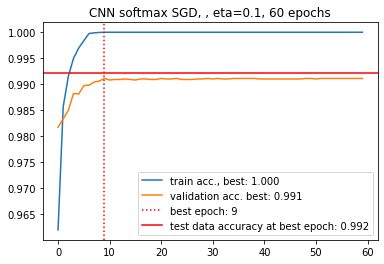

In [21]:
plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
plt.title('CNN softmax SGD, , eta={}, {} epochs'.format(eta, n_eph))
plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
plt.legend()
plt.show()

from winsound import Beep
Beep(1000, 100)

<h1>Max accuracy= 99.2%<h1/><h1>Total time= 1871s<h1/>

In [22]:
print(acc)

[0.9619200229644775, 0.9856600165367126, 0.9915199875831604, 0.994979977607727, 0.996940016746521, 0.9983800053596497, 0.9997599720954895, 0.9998800158500671, 0.9999600052833557, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [23]:
print(loss)

[0.12236244976520538, 0.04479185491800308, 0.02773158997297287, 0.016544515267014503, 0.010259032249450684, 0.005909186787903309, 0.002102147787809372, 0.0010301641887053847, 0.0006412880029529333, 0.00046312197810038924, 0.0003867401392199099, 0.0003358170797582716, 0.0002964992600027472, 0.0002686594089027494, 0.00024307866988237947, 0.0002242962218588218, 0.00020713314006570727, 0.00019209415768273175, 0.00017918254889082164, 0.00016842893091961741, 0.00015943439211696386, 0.00014993484364822507, 0.000142663178849034, 0.00013541296357288957, 0.00012920863809995353, 0.00012339169916231185, 0.00011790855205617845, 0.0001130451200879179, 0.00010860461043193936, 0.00010450561239849776, 0.00010062120418297127, 9.693281026557088e-05, 9.37244767555967e-05, 9.015841351356357e-05, 8.769218402449042e-05, 8.496611553709954e-05, 8.2274797023274e-05, 7.988986180862412e-05, 7.750614895485342e-05, 7.541304512415081e-05, 7.328698848141357e-05, 7.138817454688251e-05, 6.949851376703009e-05, 6.7777858

In [24]:
print(val_acc)

[0.9817000031471252, 0.983299970626831, 0.9850000143051147, 0.9882000088691711, 0.988099992275238, 0.9897000193595886, 0.989799976348877, 0.9904000163078308, 0.9905999898910522, 0.991100013256073, 0.9908000230789185, 0.9908999800682068, 0.9908999800682068, 0.9909999966621399, 0.9908999800682068, 0.9908000230789185, 0.9909999966621399, 0.9909999966621399, 0.9908999800682068, 0.9908999800682068, 0.991100013256073, 0.9909999966621399, 0.9909999966621399, 0.991100013256073, 0.9908999800682068, 0.9908999800682068, 0.9908999800682068, 0.9909999966621399, 0.9909999966621399, 0.991100013256073, 0.9909999966621399, 0.991100013256073, 0.9909999966621399, 0.9909999966621399, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.991100013256073, 0.991100013256073, 0.990999996662

In [25]:
print(val_loss)

[0.060853131115436554, 0.055709876120090485, 0.05170590057969093, 0.046396348625421524, 0.04694094881415367, 0.04025040939450264, 0.03957781940698624, 0.03956744447350502, 0.039531756192445755, 0.0396556630730629, 0.03992418572306633, 0.04041806608438492, 0.040454596281051636, 0.04091852903366089, 0.04122014343738556, 0.04129426181316376, 0.041655708104372025, 0.041835810989141464, 0.04176103696227074, 0.042161375284194946, 0.042315684258937836, 0.04241223633289337, 0.04252283647656441, 0.04266251251101494, 0.04277995228767395, 0.0430021658539772, 0.04302898421883583, 0.04323018714785576, 0.04332523047924042, 0.043436214327812195, 0.043519459664821625, 0.04380464553833008, 0.04385486617684364, 0.043880533427000046, 0.04397014155983925, 0.04404842108488083, 0.04408024251461029, 0.04422109201550484, 0.044362686574459076, 0.04437503218650818, 0.044479258358478546, 0.04454827308654785, 0.04462124779820442, 0.044725239276885986, 0.044790953397750854, 0.04479430615901947, 0.04487864300608635

In [18]:
sig_valid_acc = [0.9879999756813049, 0.987500011920929, 0.9879000186920166, 0.9879000186920166, 0.9878000020980835, 0.987500011920929, 0.988099992275238, 0.9883999824523926, 0.987500011920929, 0.988099992275238, 0.9879999756813049, 0.9879999756813049, 0.9878000020980835, 0.988099992275238, 0.9878000020980835, 0.9879000186920166, 0.9876000285148621, 0.9879999756813049, 0.9879999756813049, 0.9873999953269958, 0.9882000088691711, 0.9879000186920166, 0.9879000186920166, 0.9876000285148621, 0.9882000088691711, 0.988099992275238, 0.9876999855041504, 0.9879999756813049, 0.9879999756813049, 0.9883000254631042, 0.9879999756813049, 0.987500011920929, 0.9879999756813049, 0.9879999756813049, 0.9876999855041504, 0.988099992275238, 0.9876999855041504, 0.9883999824523926, 0.9879000186920166, 0.9879999756813049, 0.9879000186920166, 0.9879999756813049, 0.9878000020980835, 0.9879999756813049, 0.9878000020980835, 0.9878000020980835, 0.988099992275238, 0.9883000254631042, 0.9882000088691711, 0.9878000020980835, 0.9879999756813049, 0.9883000254631042, 0.9879000186920166, 0.9876999855041504, 0.9882000088691711, 0.9883000254631042, 0.988099992275238, 0.9879999756813049, 0.9882000088691711, 0.9882000088691711]

tanh_val__acc = [0.9817000031471252, 0.983299970626831, 0.9850000143051147, 0.9882000088691711, 0.988099992275238, 0.9897000193595886, 0.989799976348877, 0.9904000163078308, 0.9905999898910522, 0.991100013256073, 0.9908000230789185, 0.9908999800682068, 0.9908999800682068, 0.9909999966621399, 0.9908999800682068, 0.9908000230789185, 0.9909999966621399, 0.9909999966621399, 0.9908999800682068, 0.9908999800682068, 0.991100013256073, 0.9909999966621399, 0.9909999966621399, 0.991100013256073, 0.9908999800682068, 0.9908999800682068, 0.9908999800682068, 0.9909999966621399, 0.9909999966621399, 0.991100013256073, 0.9909999966621399, 0.991100013256073, 0.9909999966621399, 0.9909999966621399, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.9909999966621399, 0.991100013256073, 0.991100013256073, 0.9909999966621399, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.991100013256073, 0.991100013256073]


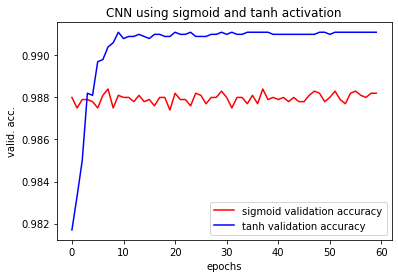

In [19]:
plt.title("CNN using sigmoid and tanh activation")
plt.plot(sig_valid_acc, c='r', label='sigmoid validation accuracy')
plt.plot(tanh_val__acc, c='b', label='tanh validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('valid. acc.')
plt.show()

<h1>sigmoid validation accuracy seems to stop growing right away, while tanh validation has large improvement over the first 10 epochs.<h1/>
<h1>M. Neilson says that both models have similar final accuracy, but my trial shows that the overall the accuracy of tahn model is much better than sigmoid (for one trial only).<h1/>
    

<h1>I will skip the open-ended question in chapter 6 for now.<h1/>
